__NB:__ Частсть ячеек с кодом сохранена в формате raw (результаты кешированы/сам код временно отключен для оптимизации времени выполнения) - они могут не отображатся в некоторых viewer-ах (в частности, в веб интерфейсе GitHub). 

### 0. Инициализация

In [1]:
# Загружаем библиотеки необходимые для выполнения кода ноутбука.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging

from utils.shortcuts import print_deep_mem_usage
from utils.s3 import print_bucket_contents, upload_file_to_s3

In [2]:
# Настройка форматов
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format',  '{:,.2f}'.format)

# Отключаем INFO сообщения от matplotlib
logging.getLogger('matplotlib').setLevel(logging.WARNING)

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (15,5)
plt.rcParams['axes.titlesize'] = 'large'
plt.rcParams['axes.labelsize'] =  'large'
plt.rcParams['xtick.labelsize'] =  'medium'
plt.rcParams['ytick.labelsize'] =  'medium'
plt.rcParams['legend.title_fontsize'] = 'large'
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['legend.framealpha'] = .9

### 1. Первый этап

#### 1.1 Загрузка первичных данных

In [3]:
tracks = pd.read_parquet('data/tracks.parquet')
cat_names = pd.read_parquet('data/catalog_names.parquet')
interactions = pd.read_parquet('data/interactions.parquet')

#### 1.2 Обзор данных

##### 1.2.1 cat_names - справочник каталожных имен

In [4]:
# Типы данных
cat_names.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 263.7 MB


In [5]:
# Визуальный осмотр данных
cat_names.head(3)

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow


In [6]:
# Диапазон значений id
cat_names['id'].describe()[['min', 'max', 'count']].astype('int')

min              0
max      101521819
count      1812471
Name: id, dtype: int64

In [7]:
# Оптимизируем типы данных
cat_names = cat_names.reset_index(drop=True)
cat_names['id'] = cat_names['id'].astype('int32')
cat_names['type'] = cat_names['type'].astype('category')
cat_names['name'] = cat_names['name'].astype('category')

# Объем памяти после оптимизации типов
print_deep_mem_usage(cat_names)

Memory usage in MB:
Index     0.00
id        6.91
type      1.73
name    124.19
Total memory usage 132.8 MB


In [8]:
# Уникальные типы каталожных единиц
cat_names['type'].value_counts()

type
track     1000000
album      658724
artist     153581
genre         166
Name: count, dtype: int64

In [9]:
# Проверка на пропуски -> отсутствуют
cat_names.isna().sum()

id      0
type    0
name    0
dtype: int64

In [10]:
# Наличие дубликатов по полю 'id' -> присутствуют
cat_names[['id']].duplicated().sum()

35774

In [11]:
# Наличие дубликатов по связке 'id', 'type' -> отсутсвуют
cat_names[['id', 'type']].duplicated().sum()

0

In [12]:
# Наличие дубликатов по связке 'type', 'name' -> присутствуют, и много
cat_names[['type', 'name']].duplicated().sum()

689769

In [13]:
# Наличие дубликатов по связке 'type', 'name' для разных типов
cat_type_name_duplicated = cat_names[cat_names[['type', 'name']].duplicated()]

for type, total_count in cat_names['type'].value_counts().to_dict().items():
    duplicated_count = len(cat_type_name_duplicated.query('type == @type'))
    display(
        f'Type [{type}] : '
        f'duplicated names {duplicated_count} of {total_count} '
        f'or {duplicated_count / total_count * 100:.1f}%.'
    )

del cat_type_name_duplicated, type, duplicated_count, total_count

'Type [track] : duplicated names 469276 of 1000000 or 46.9%.'

'Type [album] : duplicated names 218108 of 658724 or 33.1%.'

'Type [artist] : duplicated names 2385 of 153581 or 1.6%.'

'Type [genre] : duplicated names 0 of 166 or 0.0%.'

__NB! В каталоге около половины треков и трети альбомов имеют повторяющиеся (дублированные) имена.__   
Решение: оставляем как есть, корректировку (слияние) дубликатов в справочниках пока не проводим.

##### 1.2.2 tracks - данные о треках

In [14]:
tracks.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 351.0 MB


In [15]:
# визуальный отсмотр
tracks.head(3)

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]


In [16]:
# Оптимизируем типы даныых
tracks = tracks.reset_index(drop=True)
tracks['track_id'] = tracks['track_id'].astype('int32')
tracks[['albums', 'artists', 'genres']] = (
    tracks[['albums', 'artists', 'genres']]
    .map(lambda x: tuple(x.astype('int32')))
)

# Объем в памяти после оптимизации
print_deep_mem_usage(tracks)

Memory usage in MB:
Index       0.00
track_id    3.81
albums     69.65
artists    55.42
genres     58.39
Total memory usage 187.3 MB


In [17]:
# Исходное число треков
track_count_initial = len(tracks)

In [18]:
# дубликаты по 'track_id' -> отсутствуют
tracks['track_id'].duplicated().sum()

0

In [19]:
# Все ли track_id есть в справочнике -> да, все
set(tracks['track_id']) - set(cat_names.query('type == "track"')['id'])

set()

In [20]:
# все ли id альбомов есть в справочнике -> нет, не все: 
# встречаются пропуски (nan)
(
    set(tracks['albums'].explode().drop_duplicates()) 
    - set(cat_names.query('type == "album"')['id'])
)

{nan}

In [21]:
# визуальный осмотр битых идентификаторов альбомов
track_ids_with_broken_albums = (
    tracks
    .explode('albums')
    .query('albums.isna()')
    ['track_id']
    .drop_duplicates()
)
print(
    f'Tracks with broken "albums": {len(track_ids_with_broken_albums)} '
    f'or {len(track_ids_with_broken_albums) / track_count_initial :.2%} '
    'of total.\n\nSample:'
)
tracks.query('track_id in @track_ids_with_broken_albums').head(3)

Tracks with broken "albums": 18 or 0.00% of total.

Sample:


,track_id,albums,artists,genres
310821,20200372,(),(),()
310826,20200380,(),(),()
312469,20305116,(),(),()


__Проблема__: в данных о треках `tracks` есть 18 треков с отсутствующими (пустыми) значениями id альбомов.      
_Решение_: удаляем такие треки из справочника (каталога)

In [22]:
# удаляем треки с битыми (пустыми) альбомами
tracks = (
    tracks
    .query('track_id not in @track_ids_with_broken_albums')
    .reset_index(drop=True)
)
del track_ids_with_broken_albums

In [23]:
# все ли id артистов есть в справочнике -> нет, не все: 
# встречаются пропуски (nan)
(
    set(tracks['artists'].explode().drop_duplicates()) 
    - set(cat_names.query('type == "artist"')['id'])
)

{nan}

In [24]:
# визуальный осмотр битых идентификаторов артистов
track_ids_with_broken_artists = (
    tracks
    .explode('artists')
    .query('artists.isna()')
    ['track_id']
    .drop_duplicates()
)
print(
    f'Tracks with broken "artists": {len(track_ids_with_broken_artists)} '
    f'or {len(track_ids_with_broken_artists) / track_count_initial :.2%} '
    'of total.\n\nSample:'
)
tracks.query('track_id in @track_ids_with_broken_artists').head(3)

Tracks with broken "artists": 15351 or 1.54% of total.

Sample:


,track_id,albums,artists,genres
146031,3599314,"(389925,)",(),"(68, 86)"
146163,3599591,"(389944,)",(),"(68, 86)"
177544,4790215,"(533785,)",(),"(68, 86)"


__Проблема__: в данных о треках `tracks` есть ~1.5% треков с отсутствующими (пустыми) значениями id артистов.      
_Решение_: удаляем такие треки из справочника (каталога)

In [25]:
# удаляем треки с битыми (пустыми) идентификаторами артистов
tracks = (
    tracks
    .query('track_id not in @track_ids_with_broken_artists')
    .reset_index(drop=True)
)

del track_ids_with_broken_artists

In [26]:
# все ли id жанров есть в справочнике -> нет, не все: 
# встречаются как пропуски (nan) так и безимянные жанры
genre_ids_missing = (
    set(tracks['genres'].explode().drop_duplicates()) 
    - set(cat_names.query('type == "genre"')['id'])
)
print(*genre_ids_missing)

130 131 132 133 134 135 146 148 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 nan 124 126


In [27]:
# визуальный осмотр битых идентификаторов жанров
track_ids_with_broken_genres = (
    tracks
    .explode('genres')
    .query('genres in @genre_ids_missing') 
    ['track_id']
    .drop_duplicates()
)
print(
    f'Tracks with broken "genres": {len(track_ids_with_broken_genres)} '
    f'or {len(track_ids_with_broken_genres) / track_count_initial :.2%} '
    'of total.\n\nSample:'
)
tracks.query('track_id in @track_ids_with_broken_genres').head(3)

Tracks with broken "genres": 51967 or 5.20% of total.

Sample:


,track_id,albums,artists,genres
36,436,"(36,)","(330,)","(28, 164)"
59,594,"(54, 88, 5479, 5785124, 9198099, 9231427, 1088...","(533,)","(28, 162)"
125,1025,"(94, 2325, 8757, 8986, 318695, 17004129)","(937,)","(28, 162)"


__Проблема__: в данных о треках `tracks` есть ~5% треков с неизвестными или отсутствующими (пустыми) значениями id жанров.      
_Решение_: удаляем такие треки из справочника (каталога)

In [28]:
# удаляем треки с неизвестными иои пустыми идентификаторами жанров
tracks = (
    tracks
    .query('track_id not in @track_ids_with_broken_genres')
    .reset_index(drop=True)
)
del genre_ids_missing, track_ids_with_broken_genres

In [29]:
# сколько треков осталось после чистки данных
print(
    f'Cleaned tracks: {len(tracks)} '
    f'or {len(tracks) / track_count_initial:.2%} of inital count.'
)

Cleaned tracks: 932664 or 93.27% of inital count.


In [30]:
# Приборка
del track_count_initial

##### 1.2.3 interactions - взаимодействия пользователей с треками

In [31]:
interactions.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


In [32]:
# визуальный осмотр данных
interactions.head(3)

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21


In [33]:
# Посмотрим на фактическую дискретность временных меток
interactions['started_at'].drop_duplicates().sort_values().diff().min()

Timedelta('1 days 00:00:00')

In [34]:
# Оптимизация типов 
interactions = interactions.reset_index(drop=True)
interactions['started_at'] = interactions['started_at'].astype('category')

# Размер в памяти после оптимизации
print_deep_mem_usage(interactions)

Memory usage in MB:
Index          0.00
user_id      849.27
track_id     849.27
track_seq    424.63
started_at   424.64
Total memory usage 2547.8 MB


In [35]:
# исходное число записей о взаимодействиях
interactions_count_initial = len(interactions)

In [36]:
# Оценим кол-во взаимодействий с треками отсутствующими в справочнике tracks

# ids известных треков
known_track_ids = set(tracks['track_id'])

# взаимодействия с неизвестными треками
interactions_with_unknown_tracks = (
    interactions.query("track_id not in @known_track_ids")
)
print(
    'Interactions with unknown tracks: '
    f'{len(interactions_with_unknown_tracks) / interactions_count_initial:.2%} '
    'of total.'
)
del interactions_with_unknown_tracks

Interactions with unknown tracks: 3.55% of total.


Около 3% взаимодействий приходятся на треки, отсутствующие в каталоге (справочнике) `tracks`.       
_Решение_ Удаляем такие прослушивания из `interactions`

In [37]:
# Удаляем данные о прослушивании 'неизвестных' (или 'битых') треков
interactions = (
    interactions
    .query('track_id in @known_track_ids')
    .reset_index(drop=True)
)
del known_track_ids

In [38]:
# сколько взаимодействий осталось после чистки данных
print(
    f'Cleaned interactions: {len(interactions)} '
    f'or {len(interactions) / interactions_count_initial:.2%} of inital count.'
)

Cleaned interactions: 214720738 or 96.45% of inital count.


In [39]:
# Приборка
del interactions_count_initial

#### 1.3 Выводы

Проблемы с данными в исходных датасетах:
- в каталоге `cat_names` около половины(!) треков и трети альбомов имеют повторяющиеся (дублированные) имена,    
    - _Решение_: оставляем как есть, корректировку (слияние) дубликатов в справочниках пока не проводим.
- в данных о треках `tracks` есть 18 треков с отсутствующими (пустыми) значениями id альбомов,
    - _Решение_: удаляем такие треки из справочника (каталога)
- в данных о треках `tracks` есть ~1.5% треков с отсутствующими (пустыми) значениями id артистов.      
    - _Решение_: удаляем такие треки из справочника (каталога)
- в данных о треках `tracks` есть ~5% треков с неизвестными или отсутствующими (пустыми) значениями id жанров.      
    - _Решение_: удаляем такие треки из справочника (каталога)
- Около 3% взаимодействий приходятся на треки, отсутствующие в 'почищенном' каталоге (справочнике) `tracks`.       
    - _Решение:_ Удаляем такие прослушивания из `interactions`
- очевидных проблем с идентификаторами (ids) не обнаружено

### 2. Второй этап

#### 2.1 Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [40]:
# Создадим объеккт items
items = (
    tracks.copy().rename(columns={'track_id': 'item_id'}).reset_index(drop=True)
)

In [41]:
# Добавим к items строковое имя трека из каталога
items = items.join(
    cat_names.query('type == "track"').set_index('id')['name'],
    on='item_id'
).rename(columns={'name': 'item_name'})

# Визуальная проверка
items.head(3)

,item_id,albums,artists,genres,item_name
0,26,"(3, 2490753)","(16,)","(11, 21)",Complimentary Me
1,38,"(3, 2490753)","(16,)","(11, 21)",Momma's Boy
2,135,"(12, 214, 2490809)","(84,)","(11,)",Atticus


In [42]:
# Добавляем к items имена альбомов, артистов и жанров из каталога

# Создаем словари типа {id: строковое_имя}
albums_names = (cat_names.query('type == "album"').set_index('id')['name']
               .to_dict())
artists_names = (cat_names.query('type == "artist"').set_index('id')['name']
                 .to_dict())
genres_names = (cat_names.query('type == "genre"').set_index('id')['name']
               .to_dict())

# Функции преобрабования кортежа с ids (int) в кортеж с именами (строками)
get_albums_names = lambda x: tuple(map(albums_names.__getitem__, x))
get_artists_names = lambda x: tuple(map(artists_names.__getitem__, x))
get_genres_names = lambda x: tuple(map(genres_names.__getitem__, x))

items['albums_names'] = items['albums'].map(get_albums_names)
items['artists_names'] = items['artists'].map(get_artists_names)
items['genres_names'] = items['genres'].map(get_genres_names)

del (albums_names, artists_names, genres_names, get_albums_names,
     get_artists_names, get_genres_names)

# Визуальна проверка
items.head(3)

,item_id,albums,artists,genres,item_name,albums_names,artists_names,genres_names
0,26,"(3, 2490753)","(16,)","(11, 21)",Complimentary Me,"(Taller Children, Taller Children)","(Elizabeth & the Catapult,)","(pop, folk)"
1,38,"(3, 2490753)","(16,)","(11, 21)",Momma's Boy,"(Taller Children, Taller Children)","(Elizabeth & the Catapult,)","(pop, folk)"
2,135,"(12, 214, 2490809)","(84,)","(11,)",Atticus,"(Wild Young Hearts, Wild Young Hearts, Wild Yo...","(Noisettes,)","(pop,)"


In [43]:
# Проверим, что items не раздуло в пямяти после присоеденинения строковых имен
print_deep_mem_usage(items, columns_info=False)

Total memory usage 466.5 MB


In [44]:
# Создадим объект events
events = interactions.copy().rename(columns={'track_id': 'item_id'})

In [45]:
# Приберемся - cat_names, interactions, tracks больше не нужны
del cat_names, interactions, tracks

#### 2.2 EDA

In [46]:
events['user_id'].nunique()

1372042

Общее кол-во уникальных пользователей в выборке около 1.3 млн.

In [47]:
# Кол-во прослушанных треков по пользователям
track_count_by_user = (
    events.groupby('user_id').agg(tracks_listened=('item_id', 'count'))
)

# Статистики по кол-ву прослушаных треков
track_count_by_user.describe().astype('int')

,tracks_listened
count,1372042
mean,156
std,335
min,1
25%,22
50%,54
75%,149
max,16609


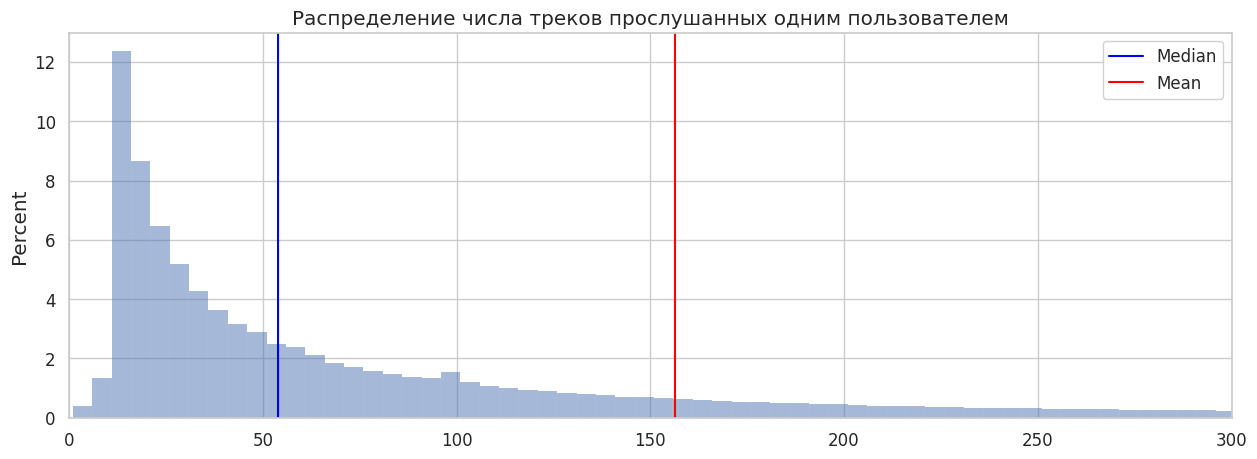

In [48]:
ax = sns.histplot(track_count_by_user, stat='percent', binwidth=5)
ax.set_xlim(0, 300)
ax.axvline(track_count_by_user['tracks_listened'].median(), color='blue',
           linestyle='-', label='Median')
ax.axvline(track_count_by_user['tracks_listened'].mean(), color='red',
           linestyle='-', label='Mean')
ax.legend()
ax.set_title('Распределение числа треков прослушанных '
             'одним пользователем')
ax.plot()
del ax, track_count_by_user

Медианное кол-ва прослушанных пользователем треков 54.      
Из-за наличия достаточного кол-ва меломанов с большим числом прослушанных треков (>1000) среднее существенно выше и составляет 156.

Расчитаем индекс популярности треков:
- для каждого трека считаем кол-во прослушавших его пользователей
- нормируем от 0 до 1 (делим на кол-во пользователей, прослушавших самый популярный трек)

In [49]:
# Расчитаем индекс популярности треков:
item_popularity = (
    events
    .groupby('item_id')
    .agg(popularity=('user_id', 'count'))
    .reset_index()
)
item_popularity['popularity'] /= item_popularity['popularity'].max()
item_popularity['popularity'] = item_popularity['popularity'].astype('float32')

# Добавим индекс популярности в таблицу items
items = items.merge(item_popularity, on='item_id', how='left')
items['popularity'] = items['popularity'].fillna(0)

del item_popularity

In [50]:
# Наиболее популярные треки
(
    items[['item_name', 'artists_names', 'genres_names', 'albums_names',
           'popularity']]
    .sort_values(by='popularity', ascending=False)
    .head(10)
)

,item_name,artists_names,genres_names,albums_names,popularity
8215,Smells Like Teen Spirit,"(Nirvana,)","(alternative, rock, allrock)","(Nevermind, Nirvana, Nevermind, Nevermind, Nev...",1.00
451664,Believer,"(Imagine Dragons,)","(rock, allrock)","(Shape Of Pop, NOW That's What I Call Music, E...",0.96
24433,Numb,"(Linkin Park,)","(numetal, metal)","(Meteora, Meteora, Meteora, Meteora, 00s Rock ...",0.92
478765,I Got Love,"(Miyagi & Эндшпиль, Рем Дигга)","(rusrap, rap)","(I Got Love, I Got Love)",0.90
774169,Юность,"(Dabro,)","(pop, ruspop)","(Юность,)",0.78
341295,Way Down We Go,"(KALEO,)","(indie,)","(Way down We Go, Summer Music 2016, A/B, DFM D...",0.78
443347,Shape of You,"(Ed Sheeran,)","(pop,)","(Shape of You, ÷, ÷, Summer Vibes, Pop)",0.77
651810,In The End,"(Tommee Profitt, Fleurie, Mellen Gi)","(rnb,)","(In the End, Christian TikTok, Trending Now 20...",0.77
83809,Shape Of My Heart,"(Sting,)","(pop, rock, allrock)","(Ten Summoner's Tales, 25 Years, The Best Of 2...",0.77
607542,Life,"(Zivert,)","(pop, ruspop)","(Life, Life, Made in Russia, Fresh Dance, Life...",0.76


Аналогичным образом расчитаем индекс популярности жанров:
- для каждого жанра считаем общее кол-во прослушиваний треков данного жанра,
- нормируем от 0 до 1 (делим на кол-во прослушиваний для самого популярного жанра)

In [51]:
# Для удобства (вос)создадим справочную таблицу по жанрам
genres = (
    items[['genres', 'genres_names']]
    .explode(['genres', 'genres_names'])
    .drop_duplicates()
    .rename(columns={'genres': 'genre_id', 'genres_names': 'genre_name'})
    .sort_values(by='genre_id')
    .reset_index(drop=True)
)

# Визуальная проверка
genres.head(3)

,genre_id,genre_name
0,1,eastern
1,2,rusrock
2,3,rusrap


In [52]:
# Сначала (снова) посчитаем кол-во прослушиваний для каждого трека
events_count = (
    events
    .groupby('item_id')
    .agg(events_count=('user_id', 'count'))
    .reset_index()
)

# После агрегации по трекам добавим информацию по жанрам
# и распакуем кортежи с идентифиакаторами жанров
events_count = (
    events_count
    .merge(items[['item_id', 'genres']], on='item_id', how='left')
    .explode('genres')
    .rename(columns={'genres': 'genre_id'})
)

# визуальная проверка
events_count.head(3)

,item_id,events_count,genre_id
0,26,5,11
0,26,5,21
1,38,8,11


In [53]:
# И наконец аггрегируем по жанрам для расчета суммарного кол-ва прослушанных
# треков по каждому жанру 
genre_popularity = (
    events_count
    .groupby('genre_id')
    .agg(popularity=('events_count', 'sum'))
)
# Нормируем
genre_popularity['popularity'] /= genre_popularity['popularity'].max()
genre_popularity['popularity'] = (genre_popularity['popularity']
                                  .astype('float32'))

# Добавляем индекс популярности к справочной таблице по жанрам
genres = genres.merge(genre_popularity, on='genre_id', how='left')
genres['popularity'] = genres['popularity'].fillna(0)

# Прибираемся
del events_count, genre_popularity

# Наиболее популярные жанры
genres.sort_values(by='popularity', ascending=False).head(10)

,genre_id,genre_name,popularity
10,11,pop,1.00
70,75,rap,0.68
89,102,allrock,0.56
19,20,ruspop,0.48
2,3,rusrap,0.46
63,68,electronics,0.33
15,16,dance,0.29
1,2,rusrock,0.24
13,14,rock,0.23
40,44,foreignrap,0.22


Неожиданный факт: наиболее популярным является жанр с именем `pop`[ular].      


Для выделения треков, которые никто не прослушал можно воспользоваться уже рассчитанным индексом популярности трека, для непрослушанных треков индекс популярности равен нулю.

In [54]:
# Количество никем не прослушанных треков
(items['popularity'] == 0).sum()

0

In [55]:
# Альтернативный способ подсчета непрослушанных треков
set(items['item_id']) - set(events['item_id'].drop_duplicates())

set()

Кто-то уже позаботился об очистке исходных данных - непрослушанные треки в справочнике (катаологе) треков отсутствуют.

#### 2.3 Сохранение данных

In [56]:
# Сохраним данные локально

# NB: признак popularuty для items, genres сохранять не будем,
# т.к. мы его считали по всей выборке событий, включая будущую тестовую выборку
items.drop(columns='popularity').to_parquet('data/items.parquet')
events.to_parquet('data/events.parquet')
genres.drop(columns='popularity').to_parquet('data/genres.parquet')

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [57]:
# Заливаем файлы
upload_file_to_s3('data/items.parquet', 'recsys/data/items.parquet')
upload_file_to_s3('data/events.parquet', 'recsys/data/events.parquet')

# Визуальная проверка содержимого бакета 
print_bucket_contents(key_pattern='recsys')

Contents of bucket 's3-student-mle-20240325-173e6ff593'
Using pattern "recsys" to filter displayed objects
----------------------------------------
File Name                                                Size (MB)
----------------------------------------
recsys/data/events.parquet                                  980.54 MB
recsys/data/items.parquet                                    65.23 MB
recsys/recommendations/personal_als.parquet                 230.17 MB
recsys/recommendations/recommendations.parquet              229.94 MB
recsys/recommendations/similar.parquet                       80.90 MB
recsys/recommendations/top_popular.parquet                    0.00 MB
----------------------------------------
Total 203 objects, size: 1.59 GB


#### 2.4 Очистка памяти - перезагружаем ядро

Можно было бы ограничится удалением переменных, но перезагрузка ядра перед 'тяжелыми' расчетами более надежный вариант.

In [58]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### 3. Третий этап

#### 3.1 Повторная инициализация после перезагрузки ядра

In [59]:
# Повторно загружаем библиотеки необходимые для выполнения кода ноутбука.
import pickle
from collections import defaultdict
from itertools import repeat

import numpy as np
import pandas as pd
import scipy.sparse
import tqdm as notebook_tqdm
from implicit.als import AlternatingLeastSquares
from sklearn.preprocessing import LabelEncoder, normalize
from catboost import CatBoostClassifier, Pool

from utils.s3 import print_bucket_contents, upload_file_to_s3
from utils.shortcuts import (print_csr_mem_usage, print_deep_mem_usage,
                             print_total_mem_usage)

/home/mle-user/mle_projects/mle-recsys-project/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [60]:
from threadpoolctl import threadpool_limits

# Следуем рекомендациям модуля implicit для оптимизации ALS
threadpool_limits(1, "blas");

In [61]:
# Настройка форматов pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format',  '{:,.2f}'.format)

In [62]:
N_RECS_USER = 50    # число рекомендаций модели для одного пользователя
N_RECS_SIMILAR = 10 # число рекомендаций похожих объектов

#### 3.2 Загрузка данных

In [ ]:
# Загружаем данные в пямять
items = pd.read_parquet('data/items.parquet')
events = pd.read_parquet('data/events.parquet')

In [ ]:
# Объем данных в пямяти после загрузки
print('Items\t: ', end=''); print_deep_mem_usage(items, columns_info=False)
print('Events\t: ', end=''); print_deep_mem_usage(events, columns_info=False)

Items	: Total memory usage 757.4 MB
Events	: Total memory usage 3685.9 MB


In [ ]:
# Для 'списочных' элементов В items пережмём ndarrays в кортежи 
# для экономии пямяти
list_like_columns = ['albums', 'artists', 'genres', 'albums_names', 
                     'artists_names', 'genres_names']

items[list_like_columns] = items[list_like_columns].map(lambda x: tuple(x))

del list_like_columns

# Визуальная проверка результата
items.head(3)

,item_id,albums,artists,genres,item_name,albums_names,artists_names,genres_names
0,26,"(3, 2490753)","(16,)","(11, 21)",Complimentary Me,"(Taller Children, Taller Children)","(Elizabeth & the Catapult,)","(pop, folk)"
1,38,"(3, 2490753)","(16,)","(11, 21)",Momma's Boy,"(Taller Children, Taller Children)","(Elizabeth & the Catapult,)","(pop, folk)"
2,135,"(12, 214, 2490809)","(84,)","(11,)",Atticus,"(Wild Young Hearts, Wild Young Hearts, Wild Yo...","(Noisettes,)","(pop,)"


In [ ]:
# В events изменим тип для started_at на категориальный 
# NB: временная дискретность - дневная
events['started_at'] = events['started_at'].astype('category').cat.as_ordered()

In [ ]:
# Объем в пямяти после оптимизации типов
print('Items\t: ', end=''); print_deep_mem_usage(items, columns_info=False)
print('Events\t: ', end=''); print_deep_mem_usage(events, columns_info=False)

Items	: Total memory usage 459.1 MB
Events	: Total memory usage 2457.3 MB


#### 3.3 Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.        
Дата разделения __16 декабря 2022__ (первый день для тестовых данных)

In [ ]:
events_train_idx = (events['started_at'] < pd.to_datetime('2022-12-16'))

events_train = events[events_train_idx].reset_index(drop=True)
events_test = events[~events_train_idx].reset_index(drop=True)

del events, events_train_idx 

In [ ]:
# Посмотрим на разницу в множествах пользователей 
# в обущающей и тестовой выборке 
users_train = set(events_train['user_id'].drop_duplicates())
users_test = set(events_test['user_id'].drop_duplicates())

# Холодные пользователи - отсутствующие в обучающей выборке
cold_users = users_test - users_train

print(f'Пользователй в обучающей выборке : {len(users_train):>10}')
print(f'Пользователй в тестовой выборке  : {len(users_test):>10}')
print(f'  в т.ч.холодные пользователи    : {len(cold_users):>10}')

Пользователй в обучающей выборке :    1341269
Пользователй в тестовой выборке  :     778789
  в т.ч.холодные пользователи    :      30773


In [ ]:
del users_test, users_train, cold_users
print_total_mem_usage()

Process memory usage: 5.56 GB


#### 3.4 Топ популярных

Расчитаем индекс (score) популярности как общее кол-во прослушиваний трека различными пользователями.       
- Отнормируем от 0 до 1, разделив на максимальное число прослушиваний одного трека.             
- Используем только обучающую выборку, берем N_RECS_USER наиболее популярных.        

___NB:___ Особенность наших данных - данные о преслушивании трека конкретным пользователем включены в events только один раз, другими словами, комбинация (user_id, item_id) в пределах таблицы events уникальна.

In [ ]:
top_popular = (
    events_train
    .groupby('item_id')
    .agg(score=('user_id', 'count'))
    .reset_index()
    .sort_values(by='score', ascending=False, ignore_index=True)
    [:N_RECS_USER]
    .reset_index(drop=True)
)
top_popular['score'] /= top_popular['score'].max()
top_popular['score'] = top_popular['score'].astype('float32')

# визуальная проверка 
top_popular.head(3)

,item_id,score
0,53404,1.00
1,33311009,0.92
2,178529,0.92


In [ ]:
# Сохраняем локально
top_popular.to_parquet('data/top_popular.parquet')

In [ ]:
# Для пользвателей из тестовой выборки подготовим таблицу с
# рекомендациями вида (user_id, item_id, score)  
top_popular_recs = (
    events_test[['user_id']]
    .drop_duplicates()
    .reset_index(drop=True)
    .merge(top_popular, how='cross')
    .reset_index(drop=True)
)
top_popular_recs.head(3)

,user_id,item_id,score
0,3,53404,1.00
1,3,33311009,0.92
2,3,178529,0.92


Подготовим функции для расчета различных метрик полученных рекомендаций:
- precision@K1, recall@K1 - точность и полнота для среза топ-K1 рекомендаций
- coverage@K2 - покрытие по объектам для cреза топ-K2 рекомендаций
- novelty@K3 - новизна по объектам для среза топ-K3 рекомендаций

In [ ]:
def get_precision_recall_metrics(
    recs: pd.DataFrame,     
    events_test: pd.DataFrame,  
    K_prc_rec: int = 5
):
    """Calculate precision@K, recall@K metrics.

    Parameters
    ----------
    - recs: reccomendations table containing `user_id, item_id, score` columns
    - events_test: events table containing `user_id, item_id`
    - K_prc_rec: at_K value for precision and recall 
    """

    # Расчет будем вести по пользователям, удовлетворяющим двум условиям:
    # 1) для них были даны рекомендации
    # 2) они взаимодействовали с объектами в тестовый период 
    effective_users = (
        set(recs['user_id'].drop_duplicates()) 
        & set(events_test['user_id'].drop_duplicates())
    )
    events_test = (
        events_test
        .query('user_id in @effective_users')
        .reset_index(drop=True)
        .copy()
    )
    recs = (
        recs
        .query('user_id in @effective_users')
        # Оставляем только top-K рекомендаций для каждого пользователя
        .sort_values(by=['user_id', 'score'], ascending=[True, False],
                     ignore_index=True)
        .groupby('user_id')
        .head(K_prc_rec)
        .reset_index(drop=True)
        .copy()
    )
    # Философский вопрос состоит в том, нужно ли удалять из тестовой выборки
    # взаимодействия с объектами, отсутствующими в обучающей выборке?
    # Примем решение, что мы так делать не будем.

    # Помечаем события в тестовой выборке как 'ground truth'
    events_test['gt'] = True

    # Сливаем события тестовой выборки с рекомендациями
    events_recs = (
        events_test[['user_id', 'item_id', 'gt']]
        .merge(
            recs[['user_id', 'item_id', 'score']],
            on=['user_id', 'item_id'],
            how='outer'
        )
    )
    # Для нерелевантных рекомендации 'gt': NaN заменяем на False 
    events_recs['gt'] = events_recs['gt'].fillna(False)

    # Размечаем рекомендованные объекты (имеющие score) как 'rec': True
    events_recs['rec'] = events_recs['score'].notna()

    # Размечаем true positive, false positive и false negative
    events_recs['tp'] = events_recs['gt'] & events_recs['rec']
    events_recs['fp'] = ~events_recs['gt'] & events_recs['rec']
    events_recs['fn'] = events_recs['gt'] & ~events_recs['rec']

    grouped = events_recs.groupby('user_id')

    precision = (
        grouped['tp'].sum() / (grouped['tp'].sum() + grouped['fp'].sum())
    )
    precision = precision.fillna(0).mean()

    recall = (
        grouped['tp'].sum() / (grouped['tp'].sum() + grouped['fn'].sum())
    )
    recall = recall.fillna(0).mean()

    return (precision, recall)

In [ ]:
def get_item_coverage_metric(
    recs: pd.DataFrame,     
    items: pd.DataFrame,    
    K_coverage: int = N_RECS_USER,
):
    """
    Calculate and return coverage@K metrics.

    Parameters
    ----------
    - recs: reccomendations table containing `user_id, item_id, score` columns
    - items: all items table containing `item_id` column
    - K_coverage: at_K value for coverage
    """

    # Берем срез топ-К
    top_k_recs = (
        recs
        .sort_values(by=['user_id', 'score'], ascending=[True, False],
                     ignore_index=True)
        .groupby('user_id')
        .head(K_coverage)
    )
    
    # кол-во уникальных объектов в К-срезах к общему кол-ву объектов
    return top_k_recs['item_id'].nunique() / len(items)

In [ ]:
def get_novelty_metric(
    recs: pd.DataFrame,   
    events_train: pd.DataFrame,
    K_novelty: int = 5
):
    """
    Calculate and return novelty@K metric.

    Parameters
    ----------
    - recs: reccomendations table containing `user_id, item_id, score` columns
    - events_trian: events table containing `user_id, item_id`
    - K_novelty: at_K value for novelty
    """

    # Отфильтруем рекомендации, оставив только топ-К
    top_k_recs = (
        recs
        .sort_values(by=['user_id', 'score'], ascending=[True, False],
                     ignore_index=True)
        .groupby('user_id')
        .head(K_novelty)
        .reset_index(drop=True)
        .copy()
    )

    # Отфильтруем данные о событиях, оставив только тех пользователей 
    # и объекты, которые есть в топ рекомендациях
    events_train = (
        events_train[
            events_train['user_id'].isin(top_k_recs['user_id'])
            & events_train['item_id'].isin(top_k_recs['item_id'])
        ]
        [['user_id', 'item_id']]
        .reset_index(drop=True)
        .copy()
    )

    # Добавим к обучающим событиям колонку 'new' : False 
    # - признак прослушивания трека конкретным пользователем
    events_train['new'] = False

    # Добавим признак 'new' к таблице рекомендаций
    top_k_recs = top_k_recs.merge(
        events_train[['user_id', 'item_id', 'new']],
        on=['user_id', 'item_id'],
        how='left'
    )
    top_k_recs['new'] = top_k_recs['new'].fillna(True).astype('bool')

    # Для топ-К рекомендаций расчитаем novelty по пользователям и усредним
    return top_k_recs.groupby('user_id')['new'].mean().mean()    

In [ ]:
def get_recs_metrics(
    recs: pd.DataFrame,     
    items: pd.DataFrame,    
    events_test: pd.DataFrame,
    events_train: pd.DataFrame,
    K_prc_rec: int = 5,
    K_coverage: int = N_RECS_USER,
    K_novelty: int = 5
):
    """
    Calculate and return precision@K, recall@K, coverage@K, novelty@K metrics.

    Parameters
    ----------
    - recs: reccomendations table containing `user_id, item_id, score` columns
    - items: all items table containing `item_id` column
    - events_test: events table containing `user_id, item_id`
    - events_trian: events table containing `user_id, item_id`
    - K_prc_rec: at_K value for precision and recall 
    - K_coverage: at_K value for coverage
    - K_novelty: at_K value for novelty
    """
    
    # print('Calculating precision_at_K...')
    precision_at_K, recall_at_K = (
        get_precision_recall_metrics(recs, events_test, K_prc_rec)
    )

    # print('Calculating coverage_at_K...')
    coverage_at_K = get_item_coverage_metric(recs, items, K_coverage)

    # print('Calculating novelty_at_K...')
    novelty_at_K = get_novelty_metric(recs, events_train, K_novelty)
    
    return {
        f'Precision@{K_prc_rec}, %': precision_at_K * 100,
        f'Recall@{K_prc_rec}, %': recall_at_K * 100,
        f'Coverage@{K_coverage}, %': coverage_at_K * 100,
        f'Novelty@{K_novelty}, %': novelty_at_K * 100,
    }


In [ ]:
# Для экономии времени - загружаем метрики из кэша
metrics = pd.read_parquet('cache/metrics_top_popular.parquet')
metrics

,"Precision@5, %","Recall@5, %","Coverage@50, %","Novelty@5, %"
Top popular,0.36,0.13,0.01,92.62


Для рекомендаций топ популярных метрики ожидаемо не ахти, но неожиданно высокая novelty 😊

In [ ]:
print_total_mem_usage()

Process memory usage: 6.01 GB


#### 3.5 Персональные ALS

__NB:__ Персональные рекомендации считаем только для пользователй и объектов  [__!__], входящих в обучающую выборку events_train (< 16 декабя 2022 года). 

In [ ]:
# Загружаем рассчитанные рекомендации из файла
personal_als = pd.read_parquet('data/personal_als.parquet')

In [ ]:
# Для экономии времени - загружаем метрики из кэша
metrics = pd.read_parquet('cache/metrics_als.parquet')
metrics

,"Precision@5, %","Recall@5, %","Coverage@50, %","Novelty@5, %"
Top popular,0.36,0.13,0.01,92.62
Personal ALS,1.59,1.20,1.31,100.00


Хороший рост метрик 👍 в сравениии с дефолтными рекомендациями топ-популярных.         
100% novelty - ожидаемо, при построении ALS рекомендации заведомо не включали в них уже прослушанные пользователем треки.

In [ ]:
print_total_mem_usage()

Process memory usage: 6.75 GB


#### 3.6 Похожие объекты

In [ ]:
print_total_mem_usage()

Process memory usage: 6.75 GB


#### 3.7 Дополнительное разбиение выборки для обучения ранжирующей модели

__NB! Методолгические замечания__           

Для обучения ранжирующей модели нам нужно выделить отдельную обучающую выборку.     

Если нарезать обучающую выборку как часть уже сужествующей тестовой выборки (например, 16-22 декабря - обучающая выборка для ранжирующей модели, 23-31 декабра - новая тестовая) - то проведенные выше расчеты рекомендаций и метрик становятся нерелевантными (изменяется размеры обучающей/тестовой выборок).     

___Для обучения ранжирующей модели возьмем часть существующей обучаюющей выборки - c 1 по 15 декабря.       
При этом для корректного обучения ранжирующей модели необходимо отдельно пересчитать рекомендации моделей топ-популярных и ALS, исключив из их обучающих выборок период 1-15 декабря.___

Обозначаниия:
- `events_train_rank_model` - события для обучения ранжирующей модели (1-15 декабря)
- `events_train_candidates` - события для обучания кандидатов для обучения ранжирующей модели (1 января - 30 ноября)

In [ ]:
# Для обучения ранжирующей модели разобъем существующую
# обучащую выборку на две части:
# 1 января - 30 ноября: расчет кандидатов для обучения модели
# 1 декабря - 15 декабря: обуечние ранжирущей модели

rank_model_train_idx = (
    events_train['started_at'] >= pd.to_datetime('2022-12-01')
)

events_train_rank_model = (
    events_train[rank_model_train_idx].reset_index(drop=True).copy()
)
events_train_candidates = (
    events_train[~rank_model_train_idx].reset_index(drop=True).copy()
)

del rank_model_train_idx

In [ ]:
print_total_mem_usage()

Process memory usage: 9.01 GB


#### 3.8 Пересчет топ-поулярных и ALS для обучения ранжирующей модели

In [ ]:
# Перерасчет индекса популярности треков на событиях до 1 декабря 
top_popular_for_rank_train = (
    events_train_candidates  # до 1 декабря
    .groupby('item_id')
    .agg(score=('user_id', 'count'))
    .reset_index()
    .sort_values(by='score', ascending=False, ignore_index=True)
    [:N_RECS_USER]
    .reset_index(drop=True)
)
top_popular_for_rank_train['score'] /= top_popular_for_rank_train['score'].max()
top_popular_for_rank_train['score'] = (top_popular_for_rank_train['score']
                                       .astype('float32'))

# визуальная проверка 
top_popular_for_rank_train.head(3)

,item_id,score
0,53404,1.00
1,178529,0.91
2,33311009,0.87


In [ ]:
# Подготовим таблицу с топ-популярными рекомендациями (user_id, item_id, score) 
# для обучения ранжирующей модели 
top_popular_recs_for_rank_train = (
    events_train_rank_model[['user_id']]  # c 1 по 15 декабря
    .drop_duplicates()
    .reset_index(drop=True)
    .merge(top_popular_for_rank_train, how='cross') # расчитаны до 1 декабря
    .reset_index(drop=True)
)
top_popular_recs_for_rank_train.head(3)

,user_id,item_id,score
0,3,53404,1.00
1,3,178529,0.91
2,3,33311009,0.87


In [ ]:
# Загружаем рекомендации als для обучения ранжирующей моделииз файла
personal_als_for_rank_train = (
    pd.read_parquet('data/personal_als_for_rank_train.parquet')
)

In [ ]:
print_total_mem_usage()

Process memory usage: 10.48 GB


#### 3.9 Построение таблиц с кандидатами для обучения/ранжирования

Обозначения:
- `candidates_for_train` - рекомендации (кандидаты) для обучения ранжирующей модели, рассчитаны на выборке `events_train_candidates` (до 1 декабря) 
- `candidates_for_inference` - рекомендации (кандидаты) для применения ранжирующей модели, рассчитаны на выборке `events_train` (до 16 декабря)

In [ ]:
# Кандидаты для обучения ранжирующей модели
candidates_for_train = pd.merge(
    top_popular_recs_for_rank_train.rename(columns={'score': 'pop_score'}),
    personal_als_for_rank_train.rename(columns={'score': 'als_score'}),
    on=['user_id', 'item_id'],
    how='outer'
)

# Кандидаты для применения ранжирующей модели
candidates_for_inference = pd.merge(
    top_popular_recs.rename(columns={'score': 'pop_score'}),
    personal_als.rename(columns={'score': 'als_score'}),
    on=['user_id', 'item_id'],
    how='outer'
)

# Визуальная проверка формата таблиц с кандидатами
candidates_for_inference.head(3)

,user_id,item_id,pop_score,als_score
0,3,53404,1.00,NaN
1,3,33311009,0.92,0.28
2,3,178529,0.92,NaN


In [ ]:
# удалим из таблиц с кандидатами рекомендации для пользователей, отсутствующих
# соответствующих тестовых выборках
candidates_for_train = candidates_for_train[
    candidates_for_train['user_id'].isin(events_train_rank_model['user_id']
                                         .drop_duplicates())
].reset_index(drop=True)

candidates_for_inference = candidates_for_inference[
    candidates_for_inference['user_id'].isin(events_test['user_id']
                                             .drop_duplicates())
].reset_index(drop=True)

In [ ]:
# Используя события events_train_rank_model (c 1 по 15 декабря) 
# разметим таргеты в таблице с кандидатами для обучения:
# 1 - если пользователь прослушал трек, иначе - 0

events_train_rank_model['target'] = 1
candidates_for_train = candidates_for_train.merge(
    events_train_rank_model[['user_id', 'item_id', 'target']], 
    on=['user_id', 'item_id'], 
    how='left'
)
candidates_for_train['target'] = (
    candidates_for_train['target'].fillna(0).astype('int8')
)

In [ ]:
# Освободим немного памяти
del (top_popular_recs, top_popular_recs_for_rank_train, 
     personal_als, personal_als_for_rank_train, events_train_rank_model)

In [ ]:
# Для обучения ранжирующей модели обеспечим баланс классов 
# в обучающей выборке не хуже 20/80:
# при наличии для пользователя релевантных рекомендаций (target=1) 
# оставляем для него не более 4 нерелевантных (target=0), остальные отбрасываем.

# Оставляем только пользователей с релевантными рекомендациями:
candidates_for_train = (
    candidates_for_train
    .groupby('user_id')
    .filter(lambda x: x['target'].sum() > 0)
)

# оставляем для таких пользователей не более 4-х нерелевантных рекомендаций:
candidates_for_train = pd.concat(
    [
        candidates_for_train.query('target == 1'),
        (
            candidates_for_train
            .query('target == 0')
            .groupby('user_id')
            .sample(4, random_state=0)
        )
    ],
    ignore_index=True
)

In [ ]:
# Итоговый баланс классов в обучающей выборке 
candidates_for_train['target'].value_counts(normalize=True)

target
0   0.65
1   0.35
Name: proportion, dtype: float64

In [ ]:
print_total_mem_usage()

Process memory usage: 10.88 GB


#### 3.10 Построение признаков

Для построения ранжирующей модели, возьмем следующие признаки:
- `popularity` - индекс популярности трека среди всех пользователей,
- `track_position` - относительное положение трека в плейлисте пользователей (среднее по всем пользователям),
- `genre_similarity` - попадание трека в жанровые предпочтения конкретного пользователя, для которого рассчитывается рекомендация.

__NB:__ для кандидатов для обучения модели(`candidates_for_train`) и кандидатов для ранжирования (`candidates_for_inference`) одни и те же признаки будут иметь различные знаения [__!__], т.к. они рассчитываюься по разным обучающим выборкам - `events_train_candidates` и `events_train` соответственно.

##### 3.10.1 Признак популярности трека

Расчитаем индекс популярности как общее кол-во прослушиваний трека различными пользователями.           
Отнормируем от 0 до 1, разделив на максимальное число прослушиваний одного трека.   

In [ ]:
# Функция для расчета индекса популярности
def get_item_popularity_scores(events: pd.DataFrame):
    """Get popularity scores based on event records:(user_id, item_id)."""
    
    item_popularity = (
        events
        .groupby('item_id')
        .agg(popularity=('user_id', 'count'))
        .reset_index()
        .sort_values(by='popularity', ascending=False, ignore_index=True)
        .reset_index(drop=True)
    )
    item_popularity['popularity'] /= item_popularity['popularity'].max()
    item_popularity['popularity'] = (
        item_popularity['popularity'].astype('float32')
    )
    return item_popularity

In [ ]:
# Добавляем признак популярности к candidates_for_train
candidates_for_train = candidates_for_train.merge(
    get_item_popularity_scores(events_train_candidates),  # <-- до 1 декабря
    on='item_id',
    how='left'
)
# визуальная проверка
candidates_for_train.head(3)

,user_id,item_id,pop_score,als_score,target,popularity
0,5,33311009,0.87,NaN,1,0.87
1,15,137670,0.57,NaN,1,0.57
2,26,60292250,0.58,0.10,1,0.58


In [ ]:
# Добавляем признак популярности к candidates_for_inference
candidates_for_inference = candidates_for_inference.merge(
    get_item_popularity_scores(events_train),  # <-- до 16 декабря
    on='item_id',
    how='left'
)
# визуальная проверка
candidates_for_inference.head(3)

,user_id,item_id,pop_score,als_score,popularity
0,3,53404,1.00,NaN,1.00
1,3,33311009,0.92,0.28,0.92
2,3,178529,0.92,NaN,0.92


In [ ]:
print_total_mem_usage()

Process memory usage: 11.12 GB


##### 3.10.2 Признак относительного положения трека в плейлистах

Рассчитаем относительное положение трека в плейлисте как `track_seq` /  max(`track_seq`) для конкретного пользователя. 

In [ ]:
def get_relative_track_position(events: pd.DataFrame) -> pd.Series:
    """Returns a series with relative track position for given events table."""

    # вычислять относительное положение трека в плейлисте 
    # будем заведомо кривым образом, но потребляющим меньше 
    # времени/пямяти отностительно стандартных 
    # методов .apply(), .transform() etc.
    
    # словарь {user_id: seq_size}
    seq_size_for_user = (
        events
        .groupby('user_id')
        ['track_seq']
        .max()
        .to_dict()
    )

    # векторизуем поиск по словарю
    get_seq_size = np.vectorize(lambda x: seq_size_for_user[x])

    return events['track_seq'] / get_seq_size(events['user_id'])

In [ ]:
# Расчитываем и добавляем в events_train_candidates относительныое положение 
# трека в плейлисте
events_train_candidates['track_position']= (
    get_relative_track_position(events_train_candidates)
    .astype('float32')
)

# Расчитываем среднее положение трека по всем пользователям
avg_track_position_for_train = (
    events_train_candidates
    .groupby('item_id')
    ['track_position']
    .mean()
    .reset_index()
)

# Добавляем признак `track_position` в таблицу candidates_for_train
candidates_for_train = candidates_for_train.merge(
    avg_track_position_for_train,
    on=['item_id'],
    how='left'
)

del avg_track_position_for_train

# визуальная проверка
candidates_for_train.head(3)

,user_id,item_id,pop_score,als_score,target,popularity,track_position
0,5,33311009,0.87,NaN,1,0.87,0.51
1,15,137670,0.57,NaN,1,0.57,0.09
2,26,60292250,0.58,0.10,1,0.58,0.74


In [ ]:
# Расчитываем и добавляем теперь уже для events_train относительныое положение 
# трека в плейлисте
events_train['track_position']= (
    get_relative_track_position(events_train)
    .astype('float32')
)

# Расчитываем среднее положение трека по всем пользователям
avg_track_position_for_inference = (
    events_train
    .groupby('item_id')
    ['track_position']
    .mean()
    .reset_index()
)

# Добавляем признак `track_position` в таблицу candidates_for_inference
candidates_for_inference = candidates_for_inference.merge(
    avg_track_position_for_inference,
    on=['item_id'],
    how='left'
)

del avg_track_position_for_inference

# визуальная проверка
candidates_for_inference.head(3)

,user_id,item_id,pop_score,als_score,popularity,track_position
0,3,53404,1.00,NaN,1.00,0.05
1,3,33311009,0.92,0.28,0.92,0.50
2,3,178529,0.92,NaN,0.92,0.11


In [ ]:
# освободим немного памяти: удалим из таблиц events_train{_...} колонки
# 'track_seq', 'started_at', 'track_position'
(
    events_train
    .drop(columns=['track_seq', 'started_at', 'track_position'], inplace=True)
)
(
    events_train_candidates
    .drop(columns=['track_seq', 'started_at', 'track_position'], inplace=True)
)

In [ ]:
print_total_mem_usage()

Process memory usage: 11.34 GB


##### 3.10.3 Признак схожести с жанровыми предпочтениями конкретного пользователя

__Метологический подход__
     
Для оценки соответствия трека жанровым предочтениям конкретного пользователя:
- построим на основе подсчета имеющихся событий разреженную матрицу жанровых предпочтений {user x genre} для всех пользователей: строки - пользователи, столбцы - жанры.
- вектор жанровой принадлежности трека у нас фактически есть в таблице items в виде списка индексов жанров, построим сам вектор разместив единицы по соответствующим индексам жанров и создадим разреженную матрицу {item x genre} - строки - объекты(треки), столбцы - жанры.
- признак схожести расчитаем как косинусное сходство векторов жанровой принадлежности трека и соответствующей строки матрицы {user x genre}

__Столкновение с реальностью__

При реализации данного подхода с использованием разреженных мартиц `scipy.sparse` (на нашей 'учебной' инфраструктуре):
- с объемами памяти все хорошо - её хватает, данные храняться в оптимальном формате и занимают минимум места,
- ___со скоростью вычислений все плохо___ - даже с учетом всех алгоритмических оптимизаций (нормализация строк матриц, сведение косинусного расстояния к простому скалярному произвдению) время расчета для 80 млн. кандидатов составляет несколько часов. 

Узким местом являются операции поиска (получения) строки матрицы по индексу и расчет скалярного произвдения sparse-векторов.       
Иллюстрация: 

In [ ]:
# Простейшие sparse-матрицы для бенчмарка скорости расчетов
user_genre_test_csr =  scipy.sparse.csr_matrix(np.array([
        [0, 1, 0, 3, 0, 5],
        [0, 1, 0, 3, 0, 5]
], dtype='float32'))

item_genre_test_csr = scipy.sparse.csr_matrix(np.array([
    [1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1]
], dtype='float32'))

In [ ]:
%%timeit
# Бенчмарк времени единичного расчета - получение вектор-строки по индексу 
# и расчет скалярного произвдения 
user_genre_test_csr[1].dot(item_genre_test_csr[1].T)[0, 0]

268 μs ± 5.41 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Что соответствует скорости обработки порядка 4 тысяч кандидатов в секунду или более 6 часов на полный расчет.

__Альтернативный метод__

Для снижения времени расчтетов используем следующие '_костыли_':      
- для оптимизации времени поиска строки по индексу используем '_наивный косплей_` sparse формата на основе dict - будем хранить матрицы в виде словарей (словарь из словарей-строк из для user_genre, словарь из кортежей индексов жанров для item_genre)
- для исключения 'дорогих' операций умножения при расчете скалярного произвдения - будем считать векторы жанровой принадлежности трека состоящими из единиц (убираем их нормировку), строки матрицы 'user_genre' нормируем по L1 (считаем 'доли' жанров), в качестве аналога косинусного сходства используем простое скалярное произведение данных векторов

Оценим скорость расчетов для альтернативного метода:

In [ ]:
# Косплеим sparse формат матриц на основе dict
user_genre_test_dict = {
    0: {1: 1, 3: 3, 5: 5},
    1: {1: 1, 3: 3, 5: 5}
}
item_genre_test_dict = {
    0: (0, 1), 
    1: (4, 5) 
}

In [ ]:
%%timeit
# Так как вектор в item_genre состоит из единиц - скалярное 
# произведение сводится к сумме компонент вектора из user_genre 
# по индексам значений в item_genre.
sum(map(user_genre_test_dict[1].get, item_genre_test_dict[1], repeat(0.)))

393 ns ± 1.71 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


Относительно исходного подхода мы проиграем по памяти (храним матрицы менее эффективно), но получим повышение скорости расчетов на 2.5 порядка [__!__] и снижение общего времени расчета до десятков секунд (плюс разумный overhead на подготовку матриц).

In [ ]:
del (user_genre_test_csr, item_genre_test_csr, user_genre_test_dict,
     item_genre_test_dict)

__Реализуем альтернативный подход__           

Создадим матрицу жанровых предпочтений {user x genre} по выборке `events_train_candidates` (события до 1 декабря)

In [ ]:
# Для уменьшения разметрности матрицы отфильтруем события в выборке
# `events_train_candidates`, оставив только пользователей, для которых
# построены рекомендации, т.е. из `candidates_for_train`
events_for_user_genre = events_train_candidates[
    events_train_candidates['user_id'].isin(candidates_for_train['user_id'])
].reset_index(drop=True)

# Добавим к матрице событий кортежи с жанрами из каталога items
events_for_user_genre = events_for_user_genre.merge(
    items[['item_id', 'genres']],
    on=['item_id'],
    how='left'
)

# Визуальная проверка формата событий для расчета матрицы
events_for_user_genre.head(1)

,user_id,item_id,genres
0,5,975,"(14, 102)"


In [ ]:
# Для ускорения последующих расчетов создадим матрицу user_genre 
# как словарь из словарей(строк матрицы) следующего формата: 
# { 
#   <id_пользователя> : {
#       <id_жанра1>: <доля_жанра1>, 
#       <id_жанра2>: <доля_жанра2>,
#       ...
#   }, 
#   ...
# }
# где <доля_жанра_i> есть относительная доля конкретного жанра среди всех
# прослушанных пользователем треков.
# NB: сумма всех долей жанров для каждого конкретного пользователя равна
# единице (т.е. каждая строка матрицы нормированна на 1 по норме L1)

user_genre = defaultdict(lambda: defaultdict(int))

# считаем кол-во прослушиваний каждого жанра каждым пользователем
for event in events_for_user_genre.itertuples(index=False):
    for genre_id in event.genres:
        user_genre[event.user_id][genre_id] += 1

# Нормируем строки
for user_id, row in user_genre.items():
    norm = sum(row.values())
    for genre_id in row:
        row[genre_id] /= norm

del events_for_user_genre, event, row, user_id, genre_id, norm

# Визуальная проверка: значение в словаре user_genre по ключу user_id=5
user_genre[5]

defaultdict(int,
            {14: 0.20422535211267606,
             102: 0.43661971830985913,
             59: 0.035211267605633804,
             383: 0.007042253521126761,
             11: 0.02112676056338028,
             13: 0.035211267605633804,
             38: 0.007042253521126761,
             47: 0.014084507042253521,
             2: 0.2112676056338028,
             41: 0.007042253521126761,
             17: 0.007042253521126761,
             25: 0.007042253521126761,
             246: 0.007042253521126761})

Подготовим матрицу жанровой принадлежности треков {item x genre} в виде словаря с индедексами жанров

In [ ]:
# Формат хранения матрицы item_genre - по ключам словаря храним только
# идентификаторы соответствующих жанров в виде кортежей:
# {
#   <id_объекта>: (<id_жанра1>, <id_жанра2>, ...),
#   ...
# }

item_genres = items.set_index('item_id')['genres'].to_dict()

# Визуальаная проверка: значение по ключу item_id=26
item_genres[26]

(11, 21)

Расчет признака `genre_similarity` как сходства двух векторов: 
- вектора жанровой принадлежности трека
- вектора жанровых предпочтений пользователя

In [ ]:
# Подготовим функцию расчета жанрового сходства для пары (user_id, item_id)
def get_genre_similarity_scalar(user_id: int, item_id: int) -> float:
    """Calculate genre similarity for pair (user_id, item_id)."""

    # Если для пользователя нет рассчитанных жанровых предпочтений (холодный
    # пользователь) то значение сходства не определено. 
    if not (user_prefs := user_genre.get(user_id)):
        return np.nan
    
    # Суммируем относительные доли для жанров соответствующих объекту
    return sum(map(user_prefs.get, item_genres[item_id], repeat(0.)))

# Векторизуем функцию
get_genre_similarity_vec = np.vectorize(
    get_genre_similarity_scalar,
    otypes=['float32']
)

In [ ]:
# Произведем расчет для candidates_for_train
candidates_for_train['genre_similarity'] = (
    get_genre_similarity_vec(
        candidates_for_train['user_id'],
        candidates_for_train['item_id']
    )
)
# Визуальная проверка
candidates_for_train.head(3)

,user_id,item_id,pop_score,als_score,target,popularity,track_position,genre_similarity
0,5,33311009,0.87,NaN,1,0.87,0.51,0.64
1,15,137670,0.57,NaN,1,0.57,0.09,NaN
2,26,60292250,0.58,0.10,1,0.58,0.74,0.10


In [ ]:
# Освободим немного пямяти
del events_train_candidates, user_genre

Теперь создадим матрицу жанровых предпочтений {user x genre} по полной выборке `events_train` (события до 16 декабря)

In [ ]:
# Для уменьшения разметрности матрицы отфильтруем события в выборке
# `events_train`, оставив только пользователей, для которых
# построены рекомендации, т.е. из `candidates_for_inference`
events_for_user_genre = events_train[
    events_train['user_id'].isin(candidates_for_inference['user_id'])
].reset_index(drop=True)

# Добавим к матрице событий кортежи с жанрами из каталога items
events_for_user_genre = events_for_user_genre.merge(
    items[['item_id', 'genres']],
    on=['item_id'],
    how='left'
)

# Визуальная проверка формата событий для расчета матрицы
events_for_user_genre.head(1)

,user_id,item_id,genres
0,3,6006252,"(11, 20)"


In [ ]:
# Аналогично подробному описанию выше создадим матрицу user_genre 
# для по полной выборки `events_train`

user_genre = defaultdict(lambda: defaultdict(int))

# считаем кол-во прослушиваний каждого жанра каждым пользователем
for event in events_for_user_genre.itertuples(index=False):
    for genre_id in event.genres:
        user_genre[event.user_id][genre_id] += 1

# Нормируем строки
for user_id, row in user_genre.items():
    norm = sum(row.values())
    for genre_id in row:
        row[genre_id] /= norm

del events_for_user_genre, event, row, user_id, genre_id, norm

# Визуальная проверка: значение в словаре user_genre по ключу user_id=5
user_genre[3]

defaultdict(int,
            {11: 0.21666666666666667,
             20: 0.2,
             70: 0.03333333333333333,
             16: 0.016666666666666666,
             3: 0.25,
             75: 0.26666666666666666,
             44: 0.016666666666666666})

Обновленная по выборке `events_train` матрица user_genre посчитана, матрица item_genre остается той же - можно считать признак `genre_similarity` для кандидатов `candidates_for_inference`.

In [ ]:
# Произведем расчет для candidates_for_inference
candidates_for_inference['genre_similarity'] = (
    get_genre_similarity_vec(
        candidates_for_inference['user_id'],
        candidates_for_inference['item_id']
    )
)
# Визуальная проверка
candidates_for_inference.head(3)

,user_id,item_id,pop_score,als_score,popularity,track_position,genre_similarity
0,3,53404,1.00,NaN,1.00,0.05,0.00
1,3,33311009,0.92,0.28,0.92,0.50,0.00
2,3,178529,0.92,NaN,0.92,0.11,0.00


In [ ]:
# Освободим немного пямяти
del item_genres, user_genre

In [ ]:
# Сохраним таблицы с кандидатами локально
candidates_for_train.to_parquet('data/candidates_for_train.parquet')
candidates_for_inference.to_parquet('data/candidates_for_inference.parquet')

In [ ]:
print_total_mem_usage()

Process memory usage: 13.11 GB


#### 3.11 Обучение ранжирующей модели и ранжирование рекомендаций

Обучим ранжирующую модель на выборке `candidates_for_train` (события с 1 по 15 декабря, кандидаты и признаки рассчитаны по событиям до 1 декабря)

In [ ]:
# Еще раз посмотрим на состав обучающих данных
candidates_for_train.head(3)

,user_id,item_id,pop_score,als_score,target,popularity,track_position,genre_similarity
0,5,33311009,0.87,NaN,1,0.87,0.51,0.64
1,15,137670,0.57,NaN,1,0.57,0.09,NaN
2,26,60292250,0.58,0.10,1,0.58,0.74,0.10


In [ ]:
# Имена фичей для ранжирующей модели
rank_model_feature_names = ['pop_score', 'als_score', 'popularity', 
                            'track_position', 'genre_similarity']

In [ ]:
# Загружаем обученную модель
rank_model = CatBoostClassifier().load_model('models/rank_model.cbm')

In [ ]:
# Посмотрим на важность призаков построенной модели
pd.DataFrame(
    rank_model.get_feature_importance(), 
    index=rank_model_feature_names, 
    columns=['Importance']
).sort_values(by='Importance', ascending=False)

,Importance
track_position,44.20
genre_similarity,20.74
als_score,19.25
popularity,12.38
pop_score,3.43


Ранжируем кандидатов из `candidates_for_inference` (кандидаты и признаки рассчитаны по событиям до 16 декабря)

In [ ]:
# Рассчитаем для кандидатов ранги как значения вероятностей по предсказаниям
# ранжирующей модели
candidates_for_inference['rank_score'] = (
    rank_model
    .predict_proba(
        Pool(data=candidates_for_inference[rank_model_feature_names])
    )
    [:, 1]
    .astype('float32')
)

Построим финальные рекомендации: для каждого пользователя берем из `candidates_for_inference` N_RECS_USER рекомендаций с наивысшим рангом.

In [ ]:
two_stage_recs = (
    candidates_for_inference
    [['user_id', 'item_id', 'rank_score']]
    .sort_values(
        by=['user_id', 'rank_score'],
        ascending=[True, False],
        ignore_index=True
    )
    .groupby('user_id')
    .head(N_RECS_USER)
    .rename(columns={'rank_score': 'score'})
    .reset_index(drop=True)
)

# Визуальная проверка
two_stage_recs.head(3)

,user_id,item_id,score
0,3,80153541,0.90
1,3,67538121,0.79
2,3,68562711,0.78


In [ ]:
# Сохраним рекомендации в файл
two_stage_recs.to_parquet('data/recommendations.parquet')

In [ ]:
del candidates_for_inference, candidates_for_train, rank_model

In [ ]:
print_total_mem_usage()

Process memory usage: 13.38 GB


#### 3.12 Оценка качества

In [ ]:
# Для экономии времени - загружаем метрики из кэша
metrics = pd.read_parquet('cache/metrics_two_stage.parquet')
metrics

,"Precision@5, %","Recall@5, %","Coverage@50, %","Novelty@5, %"
Top popular,0.36,0.13,0.01,92.62
Personal ALS,1.59,1.20,1.31,100.00
Two-stage,4.18,2.36,1.23,99.66


#### 3.11 Выводы

- использование топ-популярных треков в качестве рекомендаций требует минимальных затрат, но имеет очень низкие метрики точности/полноты.
- преход к персональным рекомендациям на основе истории взаимодействий (матрицы user x item) __качественно__ (на порядок) поднимает значение основных метрик по сравнению с рекомендациями топ-популярных. Это, однако, требует гораздо больше ресурсов (времени) на разложение матрицы взаимодействий и расчет рекомендаций отдельно для каждого пользователя, что также делает практически невозможным их расчет в режиме онлайн с учетом последних зафиксированных действий пользователя.
- применение двухстадийного подхода для улучшения упомянутых выше рекомендаций за счет создания дополнительных признаков и построения дополнительной ранжирующей модели позовляет _существенно_ (по метрикам точности/полноты - в разы!) поднять общее качество рекомендаций.       
В данной работе были использованы следющие признаки:
    - `popularity` - индекс популярности трека среди всех пользователей,
    - `track_position` - относительное положение трека в плейлисте пользователей (среднее по всем пользователям),
    - `genre_similarity` - попадание трека в жанровые предпочтения конкретного пользователя, для которого рассчитывается рекомендация.      
    
- Платой за улучгение метрик является, как и в случае с персональными рекомендациями, дополнительные достаточно ресурсоемкие вычисления для подготовки/расчета признаков для ранжирующей модели со всеми вытекающими последствиями (дополнительные затраты, невозможность онлайн обновления и т.д.)

В целом проделанная работа хорошо иллюстрирует дилемму цена/качество 😊